In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from dominion import *
import glob
from sarsa_on_policy_trainer import SarsaBootstrapAgent

# Evaluate the model evolution of 

## pre witch
<ul>
    <li> <b>rand_v0</b>:  Train with random. points per turn reward. replay buffer:1e6
    <li> <b>rand_v1</b>:  Train with random. points per turn reward. replay buffer:2e5. Faster epsilon decay
    <li> <b>combination_v0</b>: Train with random/smithycombo/RL. points per turn reward. replay buffer:1e6. Faster epsilon decay
    <li> <b>combination_v1</b>: Train with random/smithycombo/RL. points per turn reward. replay buffer:2e5. Faster epsilon decay
</ul>


## post witch
<ul>
    <li> <b>combination_with_witch_v0</b>: only Buy network. Train with random/smithycombo/RL. points per turn reward
    <li> <b>combination_with_witch_v1</b>: only Buy network. Train with random/smithycombo/RL. points per turn reward. Change act priority to increase attack priority. Add no buy data into training
    <li> <b>BuyActRL_v0</b>: Both Buy and Act network. Train with SmithyBot/RL. Points per turn. No win reward,
    <li> <b>BuyActRL_v1</b>: Both Buy and Act network. Train with SmithyBot/RL. Points per turn. Win reward:20. No points per turn.
    <li> <b>BuyActRL_v2</b>: Both Buy and Act network. Train with SmithyBot/RL. No Points per turn. No win reward,
</ul>

In [2]:
p1 = SmithyBot()
p1.record_history = 1
p2 = SmithyBot()
p2.record_history = 0
dql = SarsaBootstrapAgent()
dbuy, _ = dql.record_game(1, [p1, p2])
sa = np.array([np.concatenate([s, a]) for s, a, r, _, _, _ in dbuy])
r = np.array([r for s, a, r, _, _, _ in dbuy])
dql.length = sa.shape[0]
dql.epsilon = 0.05
dql.mtrain = 5000
dql.dropout = 0.2
# one iteration creates roughly 1e4 samples
# therefore this remembers the data of pass 40 iterations.
dql.replaybuffer = int(4e5)
dql.target_iterations = 1
dql.predict_iterations = 10
dql.epochs = 5
dql.gamma = 0.97
# incentivize short games
dql.reward_points_per_turn = 0.0
# I think having win reward makes it too noisy
dql.win_reward = 0
# print the settings
print('mtrain {:d}, replaybuffer {:d}, predict iter {:d}, epochs {:d}, gamma {:.02f}'.\
  format(dql.mtrain, dql.replaybuffer, dql.predict_iterations, dql.epochs, dql.gamma))
# a very dumb way to initiate the network weights
dql.create_model(sa, r)

Playing game# 0
Took 0.017 seconds
{<Player: SmithyBot(3, 6, 8)>: 1, <Player: SmithyBot(3, 6, 8)>: 0}
{<Player: SmithyBot(3, 6, 8)>: 33.0, <Player: SmithyBot(3, 6, 8)>: 27.0}
mtrain 5000, replaybuffer 400000, predict iter 10, epochs 5, gamma 0.97
Train on 14 samples
14/14 [==============================] - 1s 53ms/sample - loss: 19.9398 - mean_squared_error: 19.9398
Train on 14 samples
14/14 [==============================] - 1s 40ms/sample - loss: 36.2651 - mean_squared_error: 36.2651


In [3]:
data = dql.generate_data_smithy(10)

Playing game# 0
Took 9.763 seconds
{<Player: RLPlayer>: 0, <Player: SmithyBot(3, 6, 8)>: 10}
{<Player: RLPlayer>: 3.7, <Player: SmithyBot(3, 6, 8)>: 65.1}


In [5]:
test0 = dql.compute_target_old(data)[0]

In [6]:
test1 = dql.compute_target(data)[0]

In [10]:
sum(test0 != test1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [23]:
p, dql = load_rl_bot('model_upload/combination_with_witch_v1_iteration_226',version='SarsaAgent')

Playing game# 0
Took 0.026 seconds
{<Player: RandomPlayer>: 0, <Player: SmithyBot(3, 6, 8)>: 1}
{<Player: RandomPlayer>: 2.0, <Player: SmithyBot(3, 6, 8)>: 57.0}


In [9]:
compare_bots([p, SmithyBot()],100)

Took 61.018 seconds


({<Player: model_upload/combination_with_witch_v1_iteration_226>: 88,
  <Player: SmithyBot(3, 6, 8)>: 12},
 {<Player: model_upload/combination_with_witch_v1_iteration_226>: 37.87,
  <Player: SmithyBot(3, 6, 8)>: 28.79})

In [14]:
import h5py
filename = 'model_upload/combination_with_witch_v1_iteration_226_ar.h5'

with h5py.File(filename, 'r') as f:
    # List all groups
    print("Keys: %s" % f.keys())
    all_key = list(f.keys())

    # Get the data
    data = list(f[a_group_key])

Keys: <KeysViewHDF5 ['dense_4', 'dense_5', 'dense_6', 'dense_7', 'dense_8', 'dropout_3', 'dropout_4', 'dropout_5', 'dropout_6']>


In [19]:
[k for k in all_key if 'dropout' in k]

['dropout_3', 'dropout_4', 'dropout_5', 'dropout_6']

In [13]:
data

['sequential_1']

In [148]:
iteration = list(range(1,10)) + list(range(10,50,5)) + list(range(49,1000,50))
def evaluate_agent_evolution(model_name, ngame=10, pre_witch = 0, actbot = 0):
    # find all the model files
    test = glob.glob('model/'+model_name + '*')
    idx = int(np.where([x.isdigit() for x in test[0].split('_')])[0])
    iteration = np.sort(np.unique([int(fn.split('_')[idx]) for fn in test]))
    pb = BigMoney()
    [p, dql] = load_rl_bot('model/{:s}_iteration_001'.format(model_name), pre_witch = pre_witch, actbot = actbot)
    w1 = []
    w2 = []
    rl1= []
    rl2= []
    b1 = []
    b2 = []
    ngame = ngame
    for i in iteration:
        print(i)
        p, _ = load_rl_bot('model/{:s}_iteration_{:03d}'.format(model_name,i),dql, pre_witch = pre_witch, actbot = actbot)
        p.epsilon = 0
        wins1, fs1 = compare_bots([p,pb],num_games=ngame,order=1)
        wins2, fs2 = compare_bots([pb,p],num_games=ngame,order=1)
        w1.append(wins1[p])
        w2.append(wins2[p])
        rl1.append(fs1[p])
        rl2.append(fs2[p])
        b1.append(fs1[pb])
        b2.append(fs1[pb])
    iteration = np.asarray(iteration, dtype=float)
    w1 = np.asarray(w1, dtype=float)
    w2 = np.asarray(w2, dtype=float)
    rl1 = np.asarray(rl1, dtype=float)
    rl2 = np.asarray(rl2, dtype=float)
    b1 = np.asarray(b1, dtype=float)
    b2 = np.asarray(b2, dtype=float)
    fn = 'evolution/' + model_name
    with open(fn, 'wb') as f:
        pickle.dump((iteration,w1,w2,rl1,rl2,b1,b2,ngame), f)
    return (iteration,w1,w2,rl1,rl2,b1,b2,ngame)

def load_model_evolution(model_name):
    fn = 'evolution/' + model_name
    with open(fn, 'rb') as f:
        return pickle.load((iteration,w1,w2,rl1,rl2,b1,b2,ngame), f)

In [147]:
test = load_model_evolution('BuyActRL_v0')

TypeError: Function takes at most 1 positional arguments (2 given)

In [152]:
(it,w1,w2,rl1,rl2,b1,b2,ngame) = evaluate_agent_evolution('BuyActRL_v0', ngame = 1, actbot=1)

Playing game# 0
Took 0.080 seconds
1
Took 8.154 seconds
Took 0.102 seconds
2
Took 0.129 seconds
Took 0.132 seconds
3
Took 0.097 seconds
Took 0.078 seconds
4
Took 0.090 seconds
Took 0.089 seconds
5
Took 0.084 seconds
Took 0.069 seconds
6
Took 0.079 seconds
Took 0.054 seconds
7
Took 0.045 seconds
Took 0.079 seconds
8
Took 0.070 seconds
Took 0.057 seconds
9
Took 0.068 seconds
Took 0.080 seconds
10
Took 0.047 seconds
Took 0.083 seconds
11
Took 0.069 seconds
Took 0.067 seconds
12
Took 0.059 seconds
Took 0.085 seconds
13
Took 0.063 seconds
Took 0.053 seconds
14
Took 0.062 seconds
Took 0.070 seconds
15
Took 0.061 seconds
Took 0.066 seconds
16
Took 0.064 seconds
Took 0.078 seconds
17
Took 0.054 seconds
Took 0.059 seconds
18
Took 0.041 seconds
Took 0.047 seconds
19
Took 0.086 seconds
Took 0.069 seconds
20
Took 0.081 seconds
Took 0.077 seconds
21
Took 0.048 seconds
Took 0.091 seconds
22
Took 0.081 seconds
Took 0.043 seconds
23
Took 0.051 seconds
Took 0.062 seconds
24
Took 0.067 seconds
Took 0.08

Took 0.053 seconds
Took 0.038 seconds
199
Took 0.063 seconds
Took 0.048 seconds
200
Took 0.057 seconds
Took 0.043 seconds
201
Took 0.063 seconds
Took 0.070 seconds
202
Took 0.143 seconds
Took 0.072 seconds
203
Took 0.058 seconds
Took 0.049 seconds
204
Took 0.067 seconds
Took 0.045 seconds
205
Took 0.053 seconds
Took 0.042 seconds
206
Took 0.075 seconds
Took 0.051 seconds
207
Took 0.048 seconds
Took 0.052 seconds
208
Took 0.058 seconds
Took 0.062 seconds
209
Took 0.062 seconds
Took 0.060 seconds
210
Took 0.073 seconds
Took 0.052 seconds
211
Took 0.050 seconds
Took 0.051 seconds
212
Took 0.046 seconds
Took 0.046 seconds
213
Took 0.046 seconds
Took 0.057 seconds
214
Took 0.065 seconds
Took 0.054 seconds
215
Took 0.048 seconds
Took 0.052 seconds
216
Took 0.068 seconds
Took 0.061 seconds
217
Took 0.047 seconds
Took 0.056 seconds
218
Took 0.081 seconds
Took 0.046 seconds
219
Took 0.060 seconds
Took 0.061 seconds
220
Took 0.048 seconds
Took 0.046 seconds
221
Took 0.084 seconds
Took 0.055 seco

Took 0.067 seconds
Took 0.044 seconds
395
Took 0.061 seconds
Took 0.078 seconds
396
Took 0.056 seconds
Took 0.062 seconds
397
Took 0.043 seconds
Took 0.049 seconds
398
Took 0.050 seconds
Took 0.056 seconds
399
Took 0.056 seconds
Took 0.056 seconds
400
Took 0.054 seconds
Took 0.051 seconds
401
Took 0.038 seconds
Took 0.058 seconds
402
Took 0.043 seconds
Took 0.049 seconds
403
Took 0.081 seconds
Took 0.050 seconds
404
Took 0.078 seconds
Took 0.049 seconds
405
Took 0.067 seconds
Took 0.050 seconds
406
Took 0.073 seconds
Took 0.054 seconds
407
Took 0.053 seconds
Took 0.093 seconds
408
Took 0.049 seconds
Took 0.066 seconds
409
Took 0.065 seconds
Took 0.055 seconds
410
Took 0.076 seconds
Took 0.050 seconds
411
Took 0.075 seconds
Took 0.060 seconds
412
Took 0.056 seconds
Took 0.039 seconds
413
Took 0.055 seconds
Took 0.058 seconds
414
Took 0.073 seconds
Took 0.060 seconds
415
Took 0.048 seconds
Took 0.047 seconds
416
Took 0.053 seconds
Took 0.047 seconds
417
Took 0.057 seconds
Took 0.057 seco

In [ ]:
(it,w1,w2,rl1,rl2,b1,b2,ngame) = evaluate_agent_evolution('combination_with_witch_v0', ngame = 1)

Playing game# 0
Took 0.074 seconds
{<Player: RandomPlayer>: 0, <Player: SmithyBot(3, 6, 8)>: 1}
{<Player: RandomPlayer>: 5.0, <Player: SmithyBot(3, 6, 8)>: 67.0}
1
Took 8.377 seconds
Took 0.194 seconds
2
Took 0.097 seconds
Took 0.085 seconds
3
Took 0.103 seconds
Took 0.084 seconds
4
Took 0.090 seconds
Took 0.081 seconds
5
Took 0.089 seconds
Took 0.059 seconds
6
Took 0.094 seconds
Took 0.079 seconds
7
Took 0.066 seconds
Took 0.084 seconds
8
Took 0.078 seconds
Took 0.070 seconds
9
Took 0.054 seconds
Took 0.042 seconds
10
Took 0.046 seconds
Took 0.046 seconds
11
Took 0.054 seconds
Took 0.063 seconds
12
Took 0.058 seconds
Took 0.049 seconds
13
Took 0.054 seconds
Took 0.072 seconds
14
Took 0.062 seconds
Took 0.073 seconds
15
Took 0.064 seconds
Took 0.049 seconds
16
Took 0.049 seconds
Took 0.058 seconds
17
Took 0.053 seconds
Took 0.042 seconds
18
Took 0.069 seconds
Took 0.056 seconds
19
Took 0.059 seconds
Took 0.062 seconds
20
Took 0.054 seconds
Took 0.092 seconds
21
Took 0.089 seconds
Took 

Took 0.076 seconds
Took 0.050 seconds
197
Took 0.082 seconds
Took 0.052 seconds
198
Took 0.052 seconds
Took 0.057 seconds
199
Took 0.059 seconds
Took 0.053 seconds
200
Took 0.048 seconds
Took 0.044 seconds
201
Took 0.066 seconds
Took 0.056 seconds
202
Took 0.059 seconds
Took 0.059 seconds
203
Took 0.061 seconds
Took 0.063 seconds
204
Took 0.058 seconds
Took 0.049 seconds
205
Took 0.051 seconds
Took 0.041 seconds
206
Took 0.056 seconds
Took 0.061 seconds
207
Took 0.053 seconds
Took 0.054 seconds
208
Took 0.055 seconds
Took 0.064 seconds
209
Took 0.049 seconds
Took 0.052 seconds
210
Took 0.046 seconds
Took 0.079 seconds
211
Took 0.065 seconds
Took 0.056 seconds
212


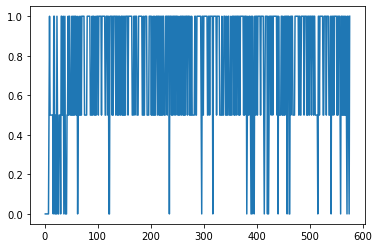

In [146]:
plt.plot(it,(w1+w2)/(2*ngame))

In [94]:
(it,w1,w2,rl1,rl2,b1,b2,ngame) = evaluate_agent_evolution('BuyActRL_v0',iteration=list(range(1,50)), ngame = 50, actbot=1)

Playing game# 0
Took 0.043 seconds


ValueError: You are trying to load a weight file containing 0 layers into a model with 6 layers.

In [119]:
p, dql = load_rl_bot('model/BuyActRL_v0_iteration_001', actbot=1)

Playing game# 0
Took 0.043 seconds


In [ ]:
(it,w1,w2,rl1,rl2,b1,b2,ngame) = evaluate_agent_evolution('combination_with_witch_v1', ngame = 50, actbot=0)

In [51]:
model_name = 'combination_with_witch_v0'
pb = BigMoney()
dql = SarsaAgent()
[p, dql] = load_rl_bot('model/{:s}_iteration_001'.format(model_name))
w1 = []
w2 = []
rl1= []
rl2= []
b1 = []
b2 = []
iteration = list(range(1,50,5)) + list(range(49,1000,50))
ngame = 50
for i in iteration:
    print(i)
    p, _ = load_rl_bot('model/{:s}_iteration_{:03d}'.format(model_name,i),dql)
    p.epsilon = 0
    wins1, fs1 = compare_bots([p,pb],num_games=ngame,order=1)
    wins2, fs2 = compare_bots([pb,p],num_games=ngame,order=1)
    w1.append(wins1[p])
    w2.append(wins2[p])
    rl1.append(fs1[p])
    rl2.append(fs2[p])
    b1.append(fs1[pb])
    b2.append(fs1[pb])
iteration = np.asarray(iteration, dtype=float)
w1 = np.asarray(w1, dtype=float)
w2 = np.asarray(w2, dtype=float)
rl1 = np.asarray(rl1, dtype=float)
rl2 = np.asarray(rl2, dtype=float)
b1 = np.asarray(b1, dtype=float)
b2 = np.asarray(b2, dtype=float)
with open(fn, 'wb') as f:
    pickle.dump((iteration,w1,w2,rl1,rl2,b1,b2), f)

Playing game# 0
Took 0.070 seconds
{<Player: RandomPlayer>: 0, <Player: SmithyBot(3, 6, 8)>: 1}
{<Player: RandomPlayer>: 6.0, <Player: SmithyBot(3, 6, 8)>: 72.0}
1
Took 1.913 seconds
Took 1.029 seconds
2
Took 0.807 seconds
Took 0.630 seconds
3
Took 0.700 seconds
Took 0.630 seconds
4
Took 0.520 seconds
Took 0.677 seconds
5
Took 0.525 seconds
Took 0.479 seconds
6
Took 0.591 seconds
Took 0.519 seconds
7
Took 0.661 seconds
Took 0.484 seconds
8
Took 0.698 seconds
Took 0.665 seconds
9
Took 0.547 seconds
Took 0.495 seconds
10
Took 0.539 seconds
Took 0.497 seconds
11
Took 0.474 seconds
Took 0.519 seconds
12
Took 0.605 seconds
Took 0.506 seconds
13
Took 0.484 seconds
Took 0.606 seconds
14
Took 0.557 seconds
Took 0.539 seconds
15
Took 0.511 seconds
Took 0.590 seconds
16
Took 0.679 seconds
Took 0.523 seconds
17
Took 0.480 seconds
Took 0.547 seconds
18
Took 0.464 seconds
Took 0.595 seconds
19
Took 0.542 seconds
Took 0.455 seconds
20
Took 0.546 seconds
Took 0.553 seconds
21
Took 0.669 seconds
Took 

Took 0.658 seconds
Took 0.552 seconds
774
Took 0.644 seconds
Took 0.631 seconds
779
Took 0.542 seconds
Took 0.490 seconds
784
Took 0.560 seconds
Took 0.548 seconds
789
Took 0.574 seconds
Took 0.466 seconds
794
Took 0.545 seconds
Took 0.528 seconds
799
Took 0.537 seconds
Took 0.472 seconds
804
Took 0.535 seconds
Took 0.470 seconds
809
Took 0.618 seconds
Took 0.535 seconds
814
Took 0.532 seconds
Took 0.432 seconds
819
Took 0.443 seconds
Took 0.394 seconds
824
Took 0.454 seconds
Took 0.454 seconds
829
Took 0.534 seconds
Took 0.525 seconds
834
Took 0.521 seconds
Took 0.420 seconds
839
Took 0.495 seconds
Took 0.465 seconds
844
Took 0.607 seconds
Took 0.418 seconds
849
Took 0.501 seconds
Took 0.409 seconds
854
Took 0.480 seconds
Took 0.561 seconds
859
Took 0.500 seconds
Took 0.438 seconds
864
Took 0.437 seconds
Took 0.469 seconds
869
Took 0.478 seconds
Took 0.423 seconds
874
Took 0.542 seconds
Took 0.571 seconds
879
Took 0.568 seconds
Took 0.387 seconds
884
Took 0.452 seconds
Took 0.454 seco

UnsupportedOperation: write